## 掛載雲端硬碟


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [2]:
# # Change to your own folder !!!
# %cd /content/drive/MyDrive/your own folder/

## Import library

In [3]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models.resnet import ResNet50

## FLOPs & Parameters & Architecture
若`resnet.py`有寫對，這部分會能夠正常跑，且 parameters 應為 23513162。

你也可以寫一個剪枝後可能的 cfg 作為模型的輸入參數，看這部分印出來的架構是否正確。

In [4]:
from thop import profile
from torchsummary import summary
from tqdm import tqdm

model = ResNet50(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 328947712.0
Params: 23513162.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]          

## 設定超參數(請填空 λ)

In [5]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-4

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000

EPOCHS = 40
LEARNING_RATE = 1e-3

LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = './model_best.pth' # Change to your own folder !!!

In [6]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [7]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

100%|██████████| 170M/170M [00:22<00:00, 7.43MB/s] 


## 定義模型與設定Optimizer & CrossEntropy Loss


In [8]:
model = ResNet50(num_classes=10)
if CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
criterion = nn.CrossEntropyLoss()

## 使用論文中稀疏化的方式更新參數(請填空)

In [9]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          ################################################
        m.weight.grad.data.add_(LAMBDA * torch.sign(m.weight.data))


## 定義訓練跟測試函數
需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

In [10]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

def train(epoch):
    print('running epoch: {}'.format(epoch+1))
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0

    # for batch_idx, (data, target) in enumerate(train_loader):
    for data, target in tqdm(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        
        # save training loss & acc 
        train_loss += loss.item() * data.size(0)
        train_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        train_total += target.size(0)
        
        # if batch_idx % LOG_INTERVAL == 0:
        #     print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
        #         epoch + 1, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.data.item()))
            
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0.0
    correct = 0
    test_total = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            test_total += target.size(0)

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
        test_acc = 100 * correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        return correct / float(len(test_loader.dataset))
    
    

##########################################################################################

best_prec1 = 0.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

best_model_path = './model_best.pth'
if os.path.exists(best_model_path):
    # model.load_state_dict(torch.load(best_model_path))
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['state_dict'])
    print(f"Loaded model weights from {best_model_path}")
else:
    print("No saved model found, starting from scratch.")


for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75, EPOCHS*0.875]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    # scheduler.step()
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        print("new best model weight, saving...")
        best_prec1 = prec1
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


No saved model found, starting from scratch.
running epoch: 1


100%|██████████| 500/500 [00:37<00:00, 13.34it/s]


Epoch [1/40] Train Loss: 1.8868 | Train Acc: 31.31%


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]



Test set: Average loss: 1.5955, Accuracy: 4154/10000 (41.5%)

new best model weight, saving...
running epoch: 2


100%|██████████| 500/500 [00:36<00:00, 13.56it/s]


Epoch [2/40] Train Loss: 1.3948 | Train Acc: 49.24%


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]



Test set: Average loss: 1.2701, Accuracy: 5510/10000 (55.1%)

new best model weight, saving...
running epoch: 3


100%|██████████| 500/500 [00:35<00:00, 13.89it/s]


Epoch [3/40] Train Loss: 1.1339 | Train Acc: 59.26%


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]



Test set: Average loss: 1.0961, Accuracy: 6102/10000 (61.0%)

new best model weight, saving...
running epoch: 4


100%|██████████| 500/500 [00:36<00:00, 13.80it/s]


Epoch [4/40] Train Loss: 0.9760 | Train Acc: 65.21%


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]



Test set: Average loss: 0.9104, Accuracy: 6774/10000 (67.7%)

new best model weight, saving...
running epoch: 5


100%|██████████| 500/500 [00:37<00:00, 13.50it/s]


Epoch [5/40] Train Loss: 0.8649 | Train Acc: 69.54%


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]



Test set: Average loss: 0.8375, Accuracy: 7044/10000 (70.4%)

new best model weight, saving...
running epoch: 6


100%|██████████| 500/500 [00:36<00:00, 13.87it/s]


Epoch [6/40] Train Loss: 0.7831 | Train Acc: 72.53%


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]



Test set: Average loss: 0.7364, Accuracy: 7440/10000 (74.4%)

new best model weight, saving...
running epoch: 7


100%|██████████| 500/500 [00:35<00:00, 13.94it/s]


Epoch [7/40] Train Loss: 0.7123 | Train Acc: 75.22%


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]



Test set: Average loss: 0.7476, Accuracy: 7453/10000 (74.5%)

new best model weight, saving...
running epoch: 8


100%|██████████| 500/500 [00:36<00:00, 13.86it/s]


Epoch [8/40] Train Loss: 0.6518 | Train Acc: 77.54%


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]



Test set: Average loss: 0.6477, Accuracy: 7803/10000 (78.0%)

new best model weight, saving...
running epoch: 9


100%|██████████| 500/500 [00:36<00:00, 13.88it/s]


Epoch [9/40] Train Loss: 0.6010 | Train Acc: 79.35%


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]



Test set: Average loss: 0.6705, Accuracy: 7712/10000 (77.1%)

running epoch: 10


100%|██████████| 500/500 [00:35<00:00, 13.94it/s]


Epoch [10/40] Train Loss: 0.5619 | Train Acc: 80.64%


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]



Test set: Average loss: 0.5739, Accuracy: 8044/10000 (80.4%)

new best model weight, saving...
running epoch: 11


100%|██████████| 500/500 [00:35<00:00, 13.95it/s]


Epoch [11/40] Train Loss: 0.5302 | Train Acc: 81.67%


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]



Test set: Average loss: 0.5530, Accuracy: 8118/10000 (81.2%)

new best model weight, saving...
running epoch: 12


100%|██████████| 500/500 [00:35<00:00, 13.89it/s]


Epoch [12/40] Train Loss: 0.5017 | Train Acc: 82.68%


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]



Test set: Average loss: 0.5411, Accuracy: 8162/10000 (81.6%)

new best model weight, saving...
running epoch: 13


100%|██████████| 500/500 [00:36<00:00, 13.87it/s]


Epoch [13/40] Train Loss: 0.4750 | Train Acc: 83.54%


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]



Test set: Average loss: 0.5216, Accuracy: 8247/10000 (82.5%)

new best model weight, saving...
running epoch: 14


100%|██████████| 500/500 [00:36<00:00, 13.86it/s]


Epoch [14/40] Train Loss: 0.4507 | Train Acc: 84.41%


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]



Test set: Average loss: 0.4779, Accuracy: 8366/10000 (83.7%)

new best model weight, saving...
running epoch: 15


100%|██████████| 500/500 [00:36<00:00, 13.73it/s]


Epoch [15/40] Train Loss: 0.4285 | Train Acc: 85.24%


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]



Test set: Average loss: 0.4583, Accuracy: 8441/10000 (84.4%)

new best model weight, saving...
running epoch: 16


100%|██████████| 500/500 [00:36<00:00, 13.62it/s]


Epoch [16/40] Train Loss: 0.3999 | Train Acc: 86.37%


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]



Test set: Average loss: 0.4757, Accuracy: 8389/10000 (83.9%)

running epoch: 17


100%|██████████| 500/500 [00:36<00:00, 13.86it/s]


Epoch [17/40] Train Loss: 0.3955 | Train Acc: 86.47%


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



Test set: Average loss: 0.4669, Accuracy: 8417/10000 (84.2%)

running epoch: 18


100%|██████████| 500/500 [00:36<00:00, 13.64it/s]


Epoch [18/40] Train Loss: 0.3723 | Train Acc: 87.14%


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



Test set: Average loss: 0.4624, Accuracy: 8427/10000 (84.3%)

running epoch: 19


100%|██████████| 500/500 [00:36<00:00, 13.72it/s]


Epoch [19/40] Train Loss: 0.3541 | Train Acc: 87.65%


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]



Test set: Average loss: 0.4785, Accuracy: 8439/10000 (84.4%)

running epoch: 20


100%|██████████| 500/500 [00:36<00:00, 13.82it/s]


Epoch [20/40] Train Loss: 0.3430 | Train Acc: 88.23%


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]



Test set: Average loss: 0.4117, Accuracy: 8631/10000 (86.3%)

new best model weight, saving...
running epoch: 21


100%|██████████| 500/500 [00:36<00:00, 13.85it/s]


Epoch [21/40] Train Loss: 0.2457 | Train Acc: 91.60%


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]



Test set: Average loss: 0.3294, Accuracy: 8903/10000 (89.0%)

new best model weight, saving...
running epoch: 22


100%|██████████| 500/500 [00:36<00:00, 13.74it/s]


Epoch [22/40] Train Loss: 0.2121 | Train Acc: 92.75%


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]



Test set: Average loss: 0.3283, Accuracy: 8917/10000 (89.2%)

new best model weight, saving...
running epoch: 23


100%|██████████| 500/500 [00:36<00:00, 13.56it/s]


Epoch [23/40] Train Loss: 0.2039 | Train Acc: 92.94%


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]



Test set: Average loss: 0.3261, Accuracy: 8931/10000 (89.3%)

new best model weight, saving...
running epoch: 24


100%|██████████| 500/500 [00:36<00:00, 13.58it/s]


Epoch [24/40] Train Loss: 0.1934 | Train Acc: 93.27%


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]



Test set: Average loss: 0.3192, Accuracy: 8963/10000 (89.6%)

new best model weight, saving...
running epoch: 25


100%|██████████| 500/500 [00:36<00:00, 13.62it/s]


Epoch [25/40] Train Loss: 0.1837 | Train Acc: 93.72%


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]



Test set: Average loss: 0.3285, Accuracy: 8931/10000 (89.3%)

running epoch: 26


100%|██████████| 500/500 [00:36<00:00, 13.58it/s]


Epoch [26/40] Train Loss: 0.1798 | Train Acc: 93.73%


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]



Test set: Average loss: 0.3214, Accuracy: 8967/10000 (89.7%)

new best model weight, saving...
running epoch: 27


100%|██████████| 500/500 [00:36<00:00, 13.53it/s]


Epoch [27/40] Train Loss: 0.1723 | Train Acc: 94.14%


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]



Test set: Average loss: 0.3210, Accuracy: 8975/10000 (89.8%)

new best model weight, saving...
running epoch: 28


100%|██████████| 500/500 [00:36<00:00, 13.58it/s]


Epoch [28/40] Train Loss: 0.1669 | Train Acc: 94.24%


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]



Test set: Average loss: 0.3192, Accuracy: 8975/10000 (89.8%)

running epoch: 29


100%|██████████| 500/500 [00:36<00:00, 13.52it/s]


Epoch [29/40] Train Loss: 0.1626 | Train Acc: 94.33%


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]



Test set: Average loss: 0.3239, Accuracy: 8969/10000 (89.7%)

running epoch: 30


100%|██████████| 500/500 [00:36<00:00, 13.52it/s]


Epoch [30/40] Train Loss: 0.1547 | Train Acc: 94.69%


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]



Test set: Average loss: 0.3198, Accuracy: 9003/10000 (90.0%)

new best model weight, saving...
running epoch: 31


100%|██████████| 500/500 [00:36<00:00, 13.60it/s]


Epoch [31/40] Train Loss: 0.1442 | Train Acc: 95.09%


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]



Test set: Average loss: 0.3195, Accuracy: 9012/10000 (90.1%)

new best model weight, saving...
running epoch: 32


100%|██████████| 500/500 [00:36<00:00, 13.59it/s]


Epoch [32/40] Train Loss: 0.1418 | Train Acc: 95.13%


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]



Test set: Average loss: 0.3152, Accuracy: 9029/10000 (90.3%)

new best model weight, saving...
running epoch: 33


100%|██████████| 500/500 [00:36<00:00, 13.62it/s]


Epoch [33/40] Train Loss: 0.1396 | Train Acc: 95.23%


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]



Test set: Average loss: 0.3155, Accuracy: 9019/10000 (90.2%)

running epoch: 34


100%|██████████| 500/500 [00:36<00:00, 13.58it/s]


Epoch [34/40] Train Loss: 0.1371 | Train Acc: 95.35%


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]



Test set: Average loss: 0.3148, Accuracy: 9040/10000 (90.4%)

new best model weight, saving...
running epoch: 35


100%|██████████| 500/500 [00:36<00:00, 13.56it/s]


Epoch [35/40] Train Loss: 0.1394 | Train Acc: 95.25%


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]



Test set: Average loss: 0.3167, Accuracy: 9016/10000 (90.2%)

running epoch: 36


100%|██████████| 500/500 [00:36<00:00, 13.59it/s]


Epoch [36/40] Train Loss: 0.1346 | Train Acc: 95.36%


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]



Test set: Average loss: 0.3156, Accuracy: 9026/10000 (90.3%)

running epoch: 37


100%|██████████| 500/500 [00:36<00:00, 13.54it/s]


Epoch [37/40] Train Loss: 0.1373 | Train Acc: 95.24%


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]



Test set: Average loss: 0.3159, Accuracy: 9030/10000 (90.3%)

running epoch: 38


100%|██████████| 500/500 [00:37<00:00, 13.50it/s]


Epoch [38/40] Train Loss: 0.1333 | Train Acc: 95.42%


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]



Test set: Average loss: 0.3183, Accuracy: 9016/10000 (90.2%)

running epoch: 39


100%|██████████| 500/500 [00:36<00:00, 13.54it/s]


Epoch [39/40] Train Loss: 0.1334 | Train Acc: 95.42%


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]



Test set: Average loss: 0.3155, Accuracy: 9024/10000 (90.2%)

running epoch: 40


100%|██████████| 500/500 [00:36<00:00, 13.53it/s]


Epoch [40/40] Train Loss: 0.1329 | Train Acc: 95.43%


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Test set: Average loss: 0.3142, Accuracy: 9016/10000 (90.2%)



## 繪製Sparsity-Training結果圖

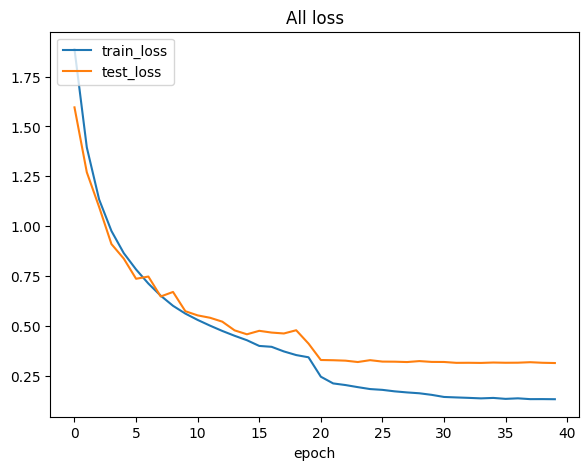

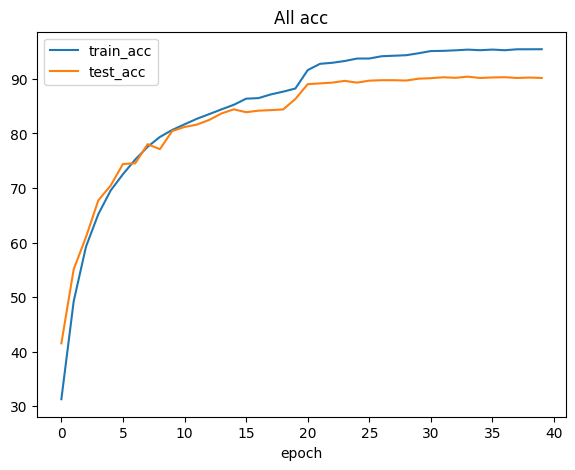

In [11]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt
def plt_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc')

    ax1.plot(train_accuracies)
    ax1.plot(test_accuracies)

    ax1.legend(['train_acc', 'test_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All loss')

    ax1.plot(train_losses)
    ax1.plot(test_losses)

    ax1.legend(['train_loss', 'test_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()


plt_loss_all()
plt_acc_all()

## 繪製scaling factor 分布圖

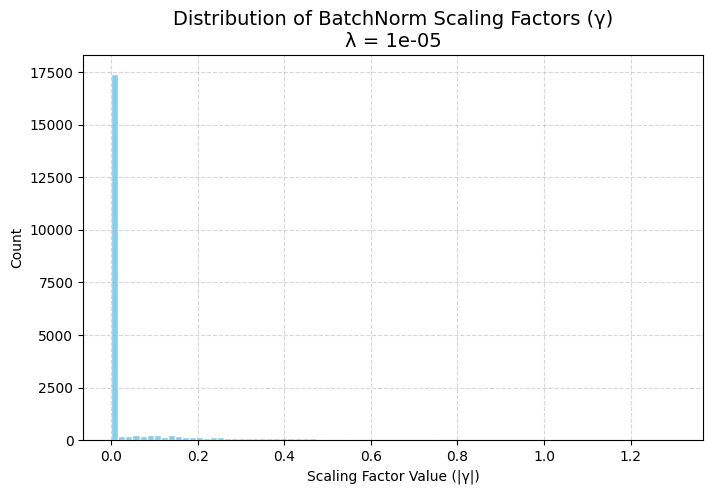

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_bn_distribution(model, lambd=0, bins=80, save_path=None):
    """繪製整個模型中所有 BatchNorm2d 層的 scaling factor (γ) 分布"""
    gammas = []

    # 收集所有 BatchNorm 的 weight (γ)
    for m in model.modules():
        if isinstance(m, torch.nn.BatchNorm2d):
            gammas.append(m.weight.data.abs().clone().cpu().numpy())

    # 合併成一個大的 array
    if len(gammas) == 0:
        print("No BatchNorm2d layers found.")
        return
    gammas = np.concatenate(gammas)

    # 繪製 histogram
    plt.figure(figsize=(8, 5))
    plt.hist(gammas, bins=bins, color='skyblue', edgecolor='white')
    plt.title(f"Distribution of BatchNorm Scaling Factors (γ)\nλ = {lambd}", fontsize=14)
    plt.xlabel("Scaling Factor Value (|γ|)")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.5)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# plot_bn_distribution(model, lambd=0)
plot_bn_distribution(model, lambd=1e-5)
# plot_bn_distribution(model, lambd=1e-4)